<a href="https://colab.research.google.com/github/eliasbaumann/UnfairGAN/blob/master/UnfairGAN_TPU_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Largely possible due to following notebooks and github code:
# https://colab.research.google.com/drive/101FjBAIMVuXyNyeUvq_Vfx-Z6CR3g4df#scrollTo=qvg-WGut_EpQ
# https://github.com/musikisomorphie/wgan-div/blob/master/wgan_div.py

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from IPython.display import clear_output
import time
import os
from datetime import datetime
import json

from google.colab import drive
from google.colab import auth

drive.mount('/content/drive')

auth.authenticate_user()

TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
with tf.Session(TPU_ADDRESS) as sess:    
    with open('/content/adc.json', 'r') as f:
        auth_info = json.load(f)
    tf.contrib.cloud.configure_gcs(sess, credentials=auth_info)
print('Found TPU at: {}'.format(TPU_ADDRESS))

In [0]:
def generate_heatmap(data,annot=True,output=False):
    if not isinstance(data,pd.DataFrame):
      data = pd.DataFrame(data)
    corr = data.corr()
    f, ax = plt.subplots(figsize=(15, 10)) #15,10
    hm = sns.heatmap(corr, annot=annot, ax=ax, cmap="coolwarm",fmt='.2f',linewidths=.05)
    f.subplots_adjust(top=0.93)
    sns.plt.show()
    return corr if output else None

def simpleLM(X_train,Y_train):
  regr = linear_model.LinearRegression()
  regr.fit(X_train,Y_train)
  res = pd.DataFrame(regr.coef_,X_train.columns)  
  return res

def simpleLogit_comparison(X_train,Y_train,X_new,Y_new):
  logit = linear_model.LogisticRegression()
  logit.fit(X_train,Y_train)
  logit_res = logit.predict(X_train)
  
  logit2 = linear_model.LogisticRegression()
  logit2.fit(X_new,Y_new)
  logit_res_2 = logit.predict(X_new)
  
  res = pd.DataFrame(data=np.column_stack((logit.coef_.T,logit2.coef_.T)),index=X_train.columns)
  return res,logit_res,logit_res_2

def simpleReg_comparison(X_train,Y_train,X_new,Y_new):
  regr = linear_model.LinearRegression()
  regr.fit(X_train,Y_train)
  regr_res = regr.predict(X_train)
  
  regr2 = linear_model.LinearRegression()
  regr2.fit(X_new,Y_new)
  regr_res_2 = regr.predict(X_new)
  
  res = pd.DataFrame(data=np.column_stack((regr.coef_.T,regr2.coef_.T)),index=X_train.columns)
  return res,regr_res,regr_res_2

def generate_gen_out_vec(df,cat_cols):
  x = np.repeat(1,len(df.columns)-len(cat_cols))
  x = np.concatenate((x,(np.max(df[cat_cols].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)))
  return x

# you can find all datasets at: http://fairness-measures.org/Pages/Datasets

# Doing 2016 sqf instead because i am lazy :)))
# columns taken from: https://github.com/adewes/fatml-pydata/blob/master/stop-and-frisk.ipynb

def gen_sqf16_data():
    #data:
    raw_sqf16 = pd.read_csv("https://www1.nyc.gov/assets/nypd/downloads/excel/analysis_and_planning/stop-question-frisk/sqf-2016.csv")

    #last row is empty
    raw_sqf16.drop(raw_sqf16.tail(1).index,inplace=True)

    numeric_attr = [
        # appearance
        'age',      # SUSPECT'S AGE                 N
        'weight',   # SUSPECT'S WEIGHT              N
        # environment
        'timestop_hour', #                          N
        'timestop_minute', # orignally timestop, converted below into two cols N
        'pct'       # PRECINCT OF STOP (FROM 1 TO 123), actually should be C, but hmm...
    ]

    cat_attr = [
        # appearance
        #'ht_feet',  # SUSPECT'S HEIGHT (FEET)       C
        'race',     # SUSPECT'S RACE                C
        'sex',      # SUSPECT'S SEX                 C
        'build',    # SUSPECT'S BUILD               C
        # environment
        'inout',    # WAS STOP INSIDE OR OUTSIDE?   C
        'trhsloc',  # WAS LOCATION HOUSING OR TRANSIT AUTHORITY? C
    ]

    yes_no_behavior_attribs = [
        'ac_evasv', # EVASIVE RESPONSE TO QUESTIONING
        'ac_assoc', # ASSOCIATING WITH KNOWN CRIMINALS
        'cs_lkout', # SUSPECT ACTING AS A LOOKOUT
        'cs_drgtr', # ACTIONS INDICATIVE OF A DRUG TRANSACTION
        'cs_casng', # CASING A VICTIM OR LOCATION
        'cs_vcrim', # VIOLENT CRIME SUSPECTED
        'ac_cgdir', # CHANGE DIRECTION AT SIGHT OF OFFICER
        'cs_furtv', # FURTIVE MOVEMENTS
        'ac_stsnd', # SIGHTS OR SOUNDS OF CRIMINAL ACTIVITY
    ]

    yes_no_environment_attribs = [
        'ac_proxm',  # PROXIMITY TO SCENE OF OFFENSE
        'cs_other',  # OTHER
        'ac_rept',   # REPORT BY VICTIM / WITNESS / OFFICER
        'ac_inves',  # ONGOING INVESTIGATION
        'ac_incid',  # AREA HAS HIGH CRIME INCIDENCE
        'ac_time',   # TIME OF DAY FITS CRIME INCIDENCE
    ]

    yes_no_appearance_attribs = [
        'cs_cloth', # WEARING CLOTHES COMMONLY USED IN A CRIME
        'cs_objcs', # CARRYING SUSPICIOUS OBJECT
        'cs_bulge', # SUSPICIOUS BULGE
        'cs_descr', # FITS A RELEVANT DESCRIPTION
        'rf_attir', # INAPPROPRIATE ATTIRE FOR SEASON
    ]

    yes_no_frisk_attribs = [
        'rf_othsw', # OTHER SUSPICION OF WEAPONS    
        'rf_knowl', # KNOWLEDGE OF SUSPECTS PRIOR CRIMINAL BEHAVIOR
        'rf_vcact', # ACTIONS OF ENGAGING IN A VIOLENT CRIME
        'rf_verbl', # VERBAL THREATS BY SUSPECT    
    ]

    yes_no_target_attribs = [
        'arstmade', # WAS AN ARREST MADE?
        'frisked',  # WAS SUSPECT FRISKED?
        'sumissue'  # WAS A SUMMONS ISSUED?
    ]

    bin_attr = np.concatenate((yes_no_behavior_attribs,yes_no_environment_attribs,yes_no_appearance_attribs,yes_no_frisk_attribs,yes_no_target_attribs))

    for attrib in bin_attr:
        raw_sqf16[attrib] = raw_sqf16[attrib].map(dict(Y=1, N=0)).apply(np.uint8)

    raw_sqf16['timestop'] = raw_sqf16['timestop'].apply(str).apply('{:0>4}'.format)
    raw_sqf16['timestop_hour'] = raw_sqf16.timestop.apply(lambda x: datetime.strptime(x,'%H%M').hour)
    raw_sqf16['timestop_minute'] = raw_sqf16.timestop.apply(lambda x: datetime.strptime(x,'%H%M').minute)
    raw_sqf16.drop('timestop',axis=1,inplace=True)


    for attrib in numeric_attr:
      raw_sqf16[attrib] = pd.to_numeric(raw_sqf16[attrib],errors='coerce')

    raw_sqf16[numeric_attr] = raw_sqf16[numeric_attr].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0)
    cat_vector =  np.concatenate((np.repeat(1,len(numeric_attr)+len(bin_attr)),np.max(raw_sqf16[cat_attr].apply(lambda x: x.astype('category')).apply(lambda x: x.cat.codes))+1)) 

    raw_sqf16 = raw_sqf16[np.concatenate((numeric_attr,bin_attr,cat_attr))]
    sqf16_dum = pd.get_dummies(data=raw_sqf16, columns = cat_attr)

    sqf16_dum.dropna(inplace=True)

    X_train_numpy = sqf16_dum.copy()
    sqf16 = tf.convert_to_tensor(sqf16_dum.values,dtype='float32')

    X_train_onehot = sqf16
    print(X_train_onehot.shape)
    return X_train_onehot,X_train_numpy,cat_vector


def gen_compas_data():
  # Used: https://github.com/propublica/compas-analysis/blob/master/Compas%20Analysis.ipynb
  # as base for what is important in that dataset as they do investigation into unfairness

  raw_compas = pd.read_csv("https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv")

  cmp = raw_compas[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count', 'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
  cmp = cmp.query('days_b_screening_arrest <= 30 and days_b_screening_arrest >= -30 and is_recid != -1 and c_charge_degree != "O" and score_text != "N/A"')
  cmp = cmp.reset_index(drop=True)


  # editing such that this will work for gan
  # age_cat and score_text can be derived from other variables and are therefore removed
  tmp = pd.Series(delta.total_seconds()/3600 for delta in (pd.to_datetime(cmp.c_jail_out)-pd.to_datetime(cmp.c_jail_in)))
  cmp['length_of_stay'] = tmp
  cmp = cmp.drop(['c_jail_out','c_jail_in','age_cat','score_text'],axis=1)

  # Prepare categorical columns
  cat_cols = ['c_charge_degree','race','sex','is_recid','two_year_recid']

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(cmp,cat_cols)

  # Create dummy variables
  cmp_dum = pd.get_dummies(data=cmp, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(cmp.columns)-len(cat_cols)
  cmp_dum.iloc[:,:num_cols] = cmp_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = cmp_dum.copy()
  cmp_dum = tf.convert_to_tensor(cmp_dum.values,dtype='float32')

  X_train_onehot = cmp_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector


# https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)

def gen_schufa_data():
  raw_schufa = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data",sep=' ',header=None)
  
  # Prepare categorical columns
  cat_cols = [0,2,3,5,6,8,9,11,13,14,16,18,19,20]

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(raw_schufa,cat_cols)

  # Create dummy variables
  schufa_dum = pd.get_dummies(data=raw_schufa, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(raw_schufa.columns)-len(cat_cols)

  schufa_dum.iloc[:,:num_cols] = schufa_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = schufa_dum.copy()
  schufa_dum = tf.convert_to_tensor(schufa_dum.values,dtype='float32')

  X_train_onehot = schufa_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector

def gen_chile_data():
  # this of course only works, if you would have access to my gdrive... 
  raw_chile = pd.read_csv('/content/drive/My Drive/unfairgan/chile dataset/ADMISION2017_Refractored_replaced.csv',sep=";")
  
  # Prepare categorical columns
  cat_cols = ['Nationality [P008]',
              'Gender [P009]',
              'Civil status [P019]',
              'Income decile [P034]',
              'Education of father [P037]',
              'Education of mother [P038]',
              'Occupational status of father [P039]',
              'Occupational status of mother [P040]',
              'Main occupation of father [P043]',
              'Main occupation of mother [P044]',
              'Region [P056]',
              'Type of high school [P077]']

  # Generate vector for number of outputs for softmax
  cat_vector = generate_gen_out_vec(raw_chile,cat_cols)

  # Create dummy variables
  chile_dum = pd.get_dummies(data=raw_chile, columns = cat_cols)

  # Rescale numeric columns
  num_cols = len(raw_chile.columns)-len(cat_cols)

  chile_dum.iloc[:,:num_cols] = chile_dum.iloc[:,:num_cols].apply(lambda x: (x-x.min())/(x.max()-x.min()), axis=0) #1,0

  X_train_numpy = chile_dum.copy()
  chile_dum = tf.convert_to_tensor(chile_dum.values,dtype='float32')

  X_train_onehot = chile_dum
  print(X_train_onehot.shape)
  return X_train_onehot,X_train_numpy,cat_vector




In [0]:
dataset_name = 'schufa'

datasets = {'sqf':gen_sqf16_data,
            'cmp':gen_compas_data,
            'schufa':gen_schufa_data,
            'chile':gen_chile_data}

MODEL_DIR = 'gs://unfairgan/model_dir/' + dataset_name

X_train_onehot,X_train_numpy,cat_vector = datasets[dataset_name]()

(1000, 63)


In [0]:
# clear bucket to reset model
if(dataset_name=='sqf'):
  !gsutil -m rm gs://unfairgan/model_dir/sqf/**
elif(dataset_name=='cmp'):
  !gsutil -m rm gs://unfairgan/model_dir/cmp/**
elif(dataset_name=='schufa'):
  !gsutil -m rm gs://unfairgan/model_dir/schufa/**
elif(dataset_name=='chile'):
  !gsutil -m rm gs://unfairgan/model_dir/chile/**
else:
  !gsutil -m rm gs://unfairgan/model_dir/**

### model

In [0]:
print_corr = False
# Hyperparameter Definition

batch_size = 128 # 128 yielded pretty good results
noise_dim = 256

iterations = 100000
learning_rate = 1e-3

#wgan div
p = 3 
k = 2

# Model Definition

def LeakyReLU(x, alpha=0.2):
  return tf.maximum(alpha * x, x)

def generator(x,training=True):
  with tf.variable_scope('Generator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,noise_dim,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,512,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.batch_normalization(x,momentum=0.99)
    out = []
    for i in cat_vector:
      if(i>1):
        out.append(tf.layers.dense(x,i,activation=tf.contrib.sparsemax.sparsemax))#tf.nn.softmax)) # sparsemax: http://proceedings.mlr.press/v48/martins16.pdf
      else:
        out.append(tf.layers.dense(x,1,activation=tf.nn.sigmoid))
    x = tf.layers.flatten(tf.concat(out,1))
    return x
  
def discriminator(x,training=True):
  with tf.variable_scope('Discriminator',reuse=tf.AUTO_REUSE):
    x = tf.layers.dense(x,noise_dim,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,512,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,384,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,128,activation=LeakyReLU)
    x = tf.layers.dropout(x,0.2)
    x = tf.layers.dense(x,1)
    return x

# Yoinked from colab notebook above, to create a data generator class

def generate_input_fn(is_training,df):
    """Creates input_fn depending on whether the code is training or not."""
    return InputFunction(is_training,df)

class InputFunction(object):
    """Wrapper class that is passed as callable to Estimator."""

    def __init__(self, is_training,df):
        self.is_training = is_training
        self.df = df

    def __call__(self, params):
        
        data = tf.data.Dataset.from_tensor_slices(self.df)
        data = data.apply(tf.data.experimental.shuffle_and_repeat(buffer_size=self.df.shape[0]))
        
        data = data.batch(batch_size, drop_remainder=True)
        data = data.prefetch(2)
        samples = data.make_one_shot_iterator().get_next()
        #samples.set_shape([batch_size, 2])
        random_noise = tf.random_normal([batch_size, noise_dim])

        features = {
            'real': samples,
            'random_noise': random_noise}
        return features

def test_noise_input_fn(params):
    np.random.seed(0)
    noise_dataset = tf.data.Dataset.from_tensors(tf.constant(np.random.randn(params['batch_size'], noise_dim), dtype=tf.float32))
    noise = noise_dataset.make_one_shot_iterator().get_next()
    return {'random_noise': noise}, None

def model_fn(features, mode, params):
  if mode == tf.estimator.ModeKeys.PREDICT:
    random_noise = features['random_noise']
    predictions = {'generated_samples': generator(random_noise,training=False)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode,predictions=predictions)

  real_data = features['real']
  random_noise = features['random_noise']
  
  training = (mode == tf.estimator.ModeKeys.TRAIN)
  fake_data = generator(random_noise,training=training)

  disc_real = discriminator(real_data)
  disc_fake = discriminator(fake_data)

  gen_cost = tf.reduce_mean(disc_fake)
  disc_cost = tf.reduce_mean(disc_real) - tf.reduce_mean(disc_fake)
  
  epsilon = tf.random_uniform(shape=[random_noise.get_shape().as_list()[0],1],minval=0.,maxval=1.)

  differences = fake_data - real_data
  interpolates = real_data + (epsilon*differences)
  gradients = tf.gradients(discriminator(interpolates),[interpolates])[0]
  slopes = tf.pow(tf.reduce_sum(tf.square(gradients),reduction_indices=[1]),p)
  gradient_penalty = tf.reduce_mean(slopes)
  disc_cost += k*gradient_penalty

  if mode == tf.estimator.ModeKeys.TRAIN:
    gen_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)
    disc_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=0., beta2=0.9,epsilon=0.1)

    g_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(gen_train_opt)
    d_tpu_opt = tf.contrib.tpu.CrossShardOptimizer(disc_train_opt)

  # update op for batch_norm layer # i dont remember what it thought here :)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
      d_step = d_tpu_opt.minimize(disc_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Discriminator'))
      g_step = g_tpu_opt.minimize(gen_cost, var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Generator'))

      increment_step = tf.assign_add(tf.train.get_or_create_global_step(), 1)
      joint_op = tf.group([d_step, g_step, increment_step])
      return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=gen_cost, train_op=joint_op)

  elif mode == tf.estimator.ModeKeys.EVAL:
    def _eval_metric_fn(disc_cost,gen_cost):
      return {'discriminator_loss': tf.metrics.mean(disc_cost),'generator_loss': tf.metrics.mean(gen_cost)}
    return tf.contrib.tpu.TPUEstimatorSpec(mode=mode, loss=tf.reduce_mean(gen_cost), eval_metrics=(_eval_metric_fn, [disc_cost, gen_cost]))
  
def sample_from_prob(samples):
  # get point where values change to find first categorical column:
  idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
  cat_vec_short = cat_vector[idx:]
  # loop over all categorical variables and sample from distributions
  for i in cat_vec_short:
    tmp = [np.random.choice(i,size=1,p=(j/np.sum(j)))[0] for j in samples.values[:,idx:i+idx]]
    dummy = np.zeros([len(tmp),i])
    dummy[np.arange(len(tmp)),tmp] = 1
    samples.values[:,idx:idx+i] = dummy
    idx += i
  return samples



# This is an attempt, where i decided to rescale the output of softmax, such that probabilities are never 0.
# def perturb_prob(x,epsilon):
#   z = ((np.max(x)-epsilon)-(np.min(x)+epsilon)) / (np.max(x)-np.min(x))*(x-np.max(x))+(np.max(x)-epsilon)
#   res = (z/np.sum(z))
#   return res

# def sample_from_prob_withperturb(samples):
#   # get point where values change to find first categorical column:
#   idx = np.where(cat_vector[:-1] != cat_vector[1:])[0][0]+1
#   cat_vec_short = cat_vector[idx:]
#   # loop over all categorical variables and sample from distributions
#   for i in cat_vec_short:
#     tmp = [np.random.choice(i,size=1,p=perturb_prob(j,0.005)) for j in samples.values[:,idx:i+idx]]
#     tmp = np.squeeze(tmp)
#     dummy = np.zeros([len(tmp),i])
#     dummy[np.arange(len(tmp)),tmp] = 1
#     samples.values[:,idx:idx+i] = dummy
#     idx += i
#   return samples


 

def store_results(samples,orig):
  samples = pd.DataFrame([s['generated_samples'][:] for s in samples])
  samples.columns = orig.columns
  #create directory
  work_dir = os.path.join(os.getcwd(), 'drive/My Drive/unfairgan/'+dataset_name)
  os.makedirs(work_dir, exist_ok=True)
  #create filename
  filename = datetime.now().strftime("data-%Y-%m-%d-%H-%M.csv")
  samples.to_csv(os.path.join(work_dir,filename))
  return samples
  
tf.set_random_seed(1234)
tf.logging.set_verbosity(0) # alternative: tf.logging.INFO
config = tf.contrib.tpu.RunConfig(cluster=tf.contrib.cluster_resolver.TPUClusterResolver(TPU_ADDRESS),
                                  #save_checkpoints_secs=None,
                                  save_checkpoints_steps=10000,
                                  save_summary_steps=None,
                                  model_dir=MODEL_DIR,
                                  tpu_config=tf.contrib.tpu.TPUConfig(iterations_per_loop=100)
                                 )

# I yoinked this part from the first colab notebook in above citations, i'm assuming
# we use the cpu to predict so that we are actually on this machine to predict

# TPU-based estimator used for TRAIN and EVAL
est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        config=config,
        train_batch_size=batch_size,
        eval_batch_size=batch_size)

# CPU-based estimator used for PREDICT (generating images)
cpu_est = tf.contrib.tpu.TPUEstimator(
        model_fn=model_fn,
        use_tpu=False,
        config=config,
        predict_batch_size=X_train_numpy.shape[0]) # predict dataset with same size???

current_step = 0

steps_per_eval = 1000

start_time = time.time()

print('Starting training process ...')
est.train(input_fn=generate_input_fn(True,X_train_onehot),max_steps=iterations)
print('generating new dataset ...')
pred_res = store_results(cpu_est.predict(input_fn=test_noise_input_fn),X_train_numpy)
print("Total runtime: %d seconds" %(time.time()-start_time))
pred_res_sampled = sample_from_prob(pred_res.copy())
if(print_corr):
  print('generating correlation matrix ...')
  generate_heatmap(pred_res_sampled,annot=False,output=False)

### Generated set evaluation

In [0]:
eval_orig = X_train_numpy.copy()
eval_gen = pred_res_sampled.copy()

idx = 0
drop_cols = []
for i in cat_vector:
  if i>1:
    drop_cols.append(idx)
    idx += i
  else:
    idx +=1

print(drop_cols)
eval_orig.drop(eval_orig.columns[drop_cols],axis=1,inplace=True)
eval_gen.drop(eval_gen.columns[drop_cols],axis=1,inplace=True)



[7, 11, 16, 26, 31, 36, 40, 43, 47, 50, 53, 57, 59, 61]


### Chile eval

In [0]:
#cat_vector
chile_indep = eval_orig.columns.tolist()
chile_dep = ['Language test score [P085]', 'Math test score [P086]']
[chile_indep.remove(i) for i in chile_dep]
tmp = np.sum(eval_gen[chile_indep]) > 0
chile_indep = tmp.index[tmp]

[None, None]

In [0]:
#simpleLogit_comparison(X_train_numpy[chile_indep],X_train_numpy[chile_dep[0]],pred_res_sampled[chile_indep],pred_res_sampled[chile_dep[0]])
comp,regr_1,regr_2 = simpleReg_comparison(eval_orig[chile_indep],eval_orig[chile_dep[1]],eval_gen[chile_indep],eval_gen[chile_dep[1]])
comp
#chile_indep

,0,1
High School Code [P012],-0.124795,-0.258945
Year of Birth [P018],0.194240,-0.072636
Nationality [P008]_2,0.009337,-0.007341
Gender [P009]_2,0.016906,0.021973
Civil status [P019]_2,-0.014433,-0.047019
Civil status [P019]_3,-0.000507,-0.018774
Civil status [P019]_4,-0.018667,0.088447
Income decile [P034]_2,0.005986,0.000423
Income decile [P034]_3,0.011921,-0.003186
Income decile [P034]_4,0.019996,-0.000851


In [0]:
plt.hist(regr_1[pred_res_sampled['Gender [P009]_1']==1],bins=30)
plt.hist(regr_2[pred_res_sampled['Gender [P009]_2']==1],bins=30,alpha=.7)

(array([4.000e+00, 2.100e+01, 8.000e+01, 1.980e+02, 3.970e+02, 6.780e+02,
        1.294e+03, 1.966e+03, 2.841e+03, 4.081e+03, 5.307e+03, 6.595e+03,
        7.880e+03, 8.706e+03, 9.546e+03, 9.920e+03, 9.590e+03, 9.100e+03,
        8.214e+03, 7.371e+03, 6.218e+03, 4.879e+03, 3.948e+03, 2.967e+03,
        2.044e+03, 1.300e+03, 7.270e+02, 3.790e+02, 1.310e+02, 1.800e+01]),
 array([0.07186314, 0.10210372, 0.13234429, 0.16258486, 0.19282543,
        0.22306601, 0.25330658, 0.28354715, 0.31378772, 0.3440283 ,
        0.37426887, 0.40450944, 0.43475001, 0.46499059, 0.49523116,
        0.52547173, 0.5557123 , 0.58595288, 0.61619345, 0.64643402,
        0.67667459, 0.70691517, 0.73715574, 0.76739631, 0.79763688,
        0.82787746, 0.85811803, 0.8883586 , 0.91859917, 0.94883975,
        0.97908032]),
 <a list of 30 Patch objects>)

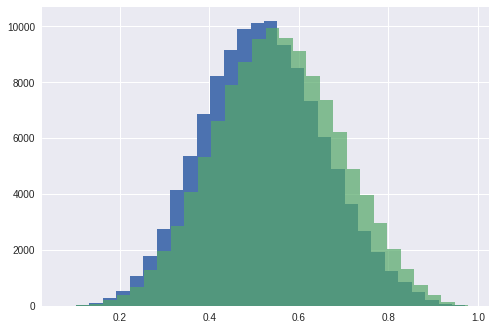

In [0]:
plt.hist(pred_res['Math test score [P086]'][pred_res_sampled['Gender [P009]_1']==1],bins=30,alpha=1)
plt.hist(pred_res['Math test score [P086]'][pred_res_sampled['Gender [P009]_2']==1],bins=30,alpha=.7)

(array([ 1020.,     0.,     0.,     0.,     0.,    44.,   174.,   439.,
          609.,   992.,  1487.,  5396.,  4092.,  4832., 11245.,  5785.,
        11151., 13685., 13200.,  9557., 10698.,  8007.,  7028.,  4447.,
         3419.,  1929.,  1255.,   702.,   612.,   310.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

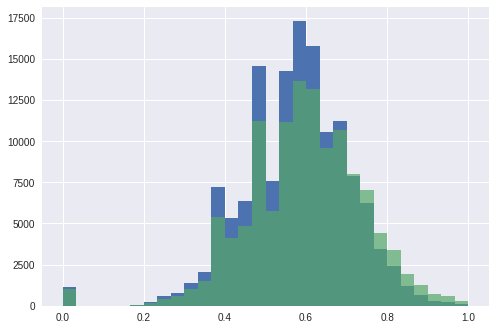

In [0]:
plt.hist(X_train_numpy['Math test score [P086]'][X_train_numpy['Gender [P009]_1']==1],bins=30,alpha=1)
plt.hist(X_train_numpy['Math test score [P086]'][X_train_numpy['Gender [P009]_2']==1],bins=30,alpha=0.7)

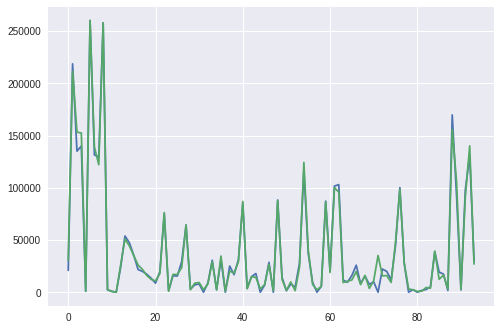

In [0]:
plt.plot(np.sum(pred_res_sampled.values,axis=0))
plt.plot(np.sum(X_train_numpy.values,axis=0))

### SQF eval

### CMP eval

In [0]:
#cat_vector
cmp_indep = eval_orig.columns.tolist()
cmp_dep = ['is_recid_1','two_year_recid_1']
[cmp_indep.remove(i) for i in cmp_dep]
tmp = np.sum(eval_gen[cmp_indep]) > 0
cmp_indep = tmp.index[tmp]

In [0]:
cmp_comp,cmp_regr_1,cmp_regr_2 = simpleLogit_comparison(eval_orig[cmp_indep],eval_orig[cmp_dep[1]],eval_gen[cmp_indep],eval_gen[cmp_dep[1]])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


(array([1768.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0., 3248.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

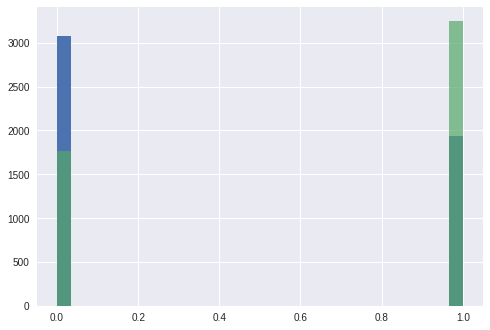

In [0]:
#plt.hist(cmp_regr_1[pred_res_sampled['sex_Male']==1],bins=30)
#plt.hist(cmp_regr_2[pred_res_sampled['sex_Male']==1],bins=30,alpha=.7)
# TODO

### Schufa eval

In [0]:
#cat_vector
schufa_indep = eval_orig.columns.tolist()
schufa_dep = schufa_indep[-1]
schufa_indep = schufa_indep[:-1]
tmp = np.sum(eval_gen[schufa_indep]) > 0
schufa_indep = tmp.index[tmp]

In [0]:
schufa_comp,schufa_regr_1,schufa_regr_2 = simpleLogit_comparison(eval_orig[schufa_indep],eval_orig[schufa_dep],eval_gen[schufa_indep],eval_gen[schufa_dep])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [0]:
schufa_comp

,0,1
1,1.686473,2.754965
4,1.643226,1.253950
7,0.817782,1.035598
10,0.031862,0.106563
12,-0.607136,-0.932559
15,0.619429,0.330262
17,0.217918,0.528626
0_A12,-0.313413,0.025846
0_A13,-0.846331,-0.229949
0_A14,-1.598474,-1.468808
